# Recommender Systems with Collaborative Filtering: Recommending Restaurants

An exploration of recommender systems to recommend restaurants given either a restaurant or a user, adapted item-based collaborative filtering concepts and techniques.

#### Kuan-I Lu / Lucas Joseph / Caitlyn Vasquez / Richard Keith
#### 2024-12-11

## Introduction 

Our group implemented an *item-based collaborative filtering recommender system* to generate restaurant recommendations using a publicly available dataset of businesses and user reviews from Yelp. After fitting a K-nearest neighbors model to the dataset, we used the model to generate 10 restaurant recommendations using similarity between restaurants given either a restaurant or a user.

Our group was interested in a project where we were able to work with a large dataset and create a model that we ourselves could use. The Yelp dataset that we chose is extensive enough to generate useful results and include restaurants in Santa Barbara and our respective hometowns. 

### Data Description

We obtained our restaurant review datasets by downloading Yelp’s public dataset, which included data for the business (restaurant) reviews for each restaurant by multiple users. Since the algorithm and the model we adapted is not time sensitive and doesn’t require real time data, we didn’t choose to use API and use the static dataset instead. Also, we’re only focusing on variables required for collaborative filtering which are `review_id`, `user_id`, `restaurant`, and `stars`(ratings). The link to the dataset can be found [here](https://www.yelp.com/dataset/download).

## Methodology

### Background Information

There are two types of recommender systems: 

- **Content-based** systems involve using the properties of the items(or in our case restaurants) themselves to find similar items that the user is most likely to enjoy. This can be done by transforming the features of an item into a vector, calculating the distance between vectors of other items using cosine similarity, and returning items with high similarity.

- **Collaborative filtering** systems instead involve using user ratings to compute the similarity between either users or items, to generate a new rating. 

    - In a user based system, a user’s ratings for items are vectorized and then used to calculate cosine similarity between each user.

    - In an item based system, an item's ratings by all users are vectorized and used to calculate cosine similarity between each item.

Across both types of systems, the metric of **cosine similarity** is the basis for generating predictions:

$$S_C(A, B) := cos(\theta) = \frac{A \cdot B}{\|A\|\|B \|} = \frac{\sum_{i=1}^{n}{A_iB_i}}{\sqrt{\sum_{i=1}^{n}A_i^2}\cdot\sqrt{\sum_{i=1}^{n}B_i^2}}$$

We can use cosine similarity to calculate the distance between two vectors. A larger value implies a lower distance and higher similarity, and a lower value implies higher distance and lower similarity.

For the final step to implement our desired model of a collaborative filtering system, we will use the `NearestNeighbors` function from the `sklearn` package to compute pairwise distance between all items or users in the dataset using cosine similarity. This allows us to return a list of the restuarants with the highest cosine similarity.



### Project Steps
For this project, we want to adapt the item-based collaborative filtering to return 10 recommended restaurants for a given input (a restaurant or a user). The approach we're going with is to first create the user item matrix, which has all unique values on one axis and all unique restaurants on the other. The values that this matrix takes are the ratings of the corresponding restaurant by the corresponding user. Note that this will be a sparse and large matrix, which is less of a problem to our cosine similarity approach. 

The goal of the first model is to input a restaurant and recommend similar ones. Using the user-item matrix we obtained, we compute the cosine similarity between the selected restaurant and all other restaurants, from which we select 10 restaurants with the closest distance as our recommendations. To achieve this, we leverage the `NearestNeighbors` function in the `sklearn.neighbors` package.

For the second model, we want to build on the first dataset and change the input from a restaurant to a user. The goal of this model is to recommend restaurants given a user's history and preference (extracted from their past ratings). The model takes a user existing in the data set as input, and creates a list of all the top rated restaurants by this user. From this list, the model then uses the same KNN method with cosine similarity to create a combined list of 10 recommendations for each of the top rated restaurants. From the recommended list we then filtered out the user rated restaurants (so that we don't recommend places the users have already been to), and then returned 10 restaurants with the closest cosine similarity. 


### Load and Clean the Dataset

Here we will be cleaning the dataset with pandas and numpy. 

In [4]:
#!pip install missingno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import missingno as msno
import pandoc
warnings.filterwarnings('ignore')

In [6]:
business = pd.read_json(r"C:\Users\brian\Projects\PSTAT 134\data\yelp_academic_dataset_business.json", lines=True)
review = pd.read_json(r"C:\Users\brian\Projects\PSTAT 134\data\yelp_academic_dataset_review.json", lines=True)

In [7]:
# Select only the useful column from review
review = review[['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool']]

# Check the unique values of the dataset
print("Number of businesses: ", business['business_id'].nunique())
print("Number of reviews: ", review.shape[0])
print("Number of reviewed businesses: ", review['business_id'].nunique())
print("Number of users who left a reiew: ", review['user_id'].nunique())

Number of businesses:  150346
Number of reviews:  6990280
Number of reviewed businesses:  150346
Number of users who left a reiew:  1987929


From the business dataset, we have information of 150,346 distinct businesses.
From the review dataset, we have 6,990,280 reviews, on the 150,346 distinct businesses, by 1,987,929 distinct users.
   
Note we will mainly use the review dataset for our model since that's what's required for the collaborative filtering algorithm.

### Data Cleaning

#### `restaurants`

First, since this project is a restaurant recommender, and Yelp contains all kinds of business in their dataset, we will focus on the businesses with "Food" or "Restaurants" in their `categories`. After filtering, we call the filtered dataset "restaurant".

In [8]:
# Filter only businesses that are restaurants
restaurants = business[business['categories'].str.contains("Food|Restaurants", na=False, case=False)]

print("Number of restaurants: ", restaurants['business_id'].nunique())

Number of restaurants:  64616


Note that now we only have 64616 unique restaurants.

In addition, we also want to focus on the restaurants that are still in business (ie. `is_open` = 1).

In [9]:
restaurants = restaurants[restaurants['is_open'] == 1]

print("Number of restaurants in business: ", restaurants['business_id'].nunique())

Number of restaurants in business:  44582


Note that we only have 44582 restaurants in business.

#### `review_clean`

For the sake of saving memory space, we filter out the text review the moment we imported the review data. Notice that the explicit data include stars, useful, funny, and cool, which we will focus on using stars for the purpose of this project. In addition, we assign the review id as the row number of that review.

In [10]:
# Select the useful columns
review_clean = (
    review
    .assign(review_id=lambda x: x.index)  # Create `review_id` 
    .loc[:, ['review_id', 'user_id', 'business_id', 'stars']]  # Select necessary columns
)

Also, since we're only focusing on the restaurants, we only want to work with reviews on restaurants (businesses_ids in the restaurant dataset).

In [11]:
# Filter only reviews on restaurants
review_clean = review_clean[
    review_clean['business_id'].isin(restaurants['business_id'])
]

print("Number of reviews on restaurants: ", review_clean.shape[0])
print("Number of reviewed restaurants: ", review_clean['business_id'].nunique())
print("Number of users who left a reiew on restaurants: ", review_clean['user_id'].nunique())

Number of reviews on restaurants:  4104995
Number of reviewed restaurants:  44582
Number of users who left a reiew on restaurants:  1333169


After filtering, we reduce the number of reviews to 4104995, with 44582 restaurants rated by 1333169 users.
  
Lastly, we check for missing values to see if any imputation is needed.

Missing values: 0


<Figure size 400x200 with 0 Axes>

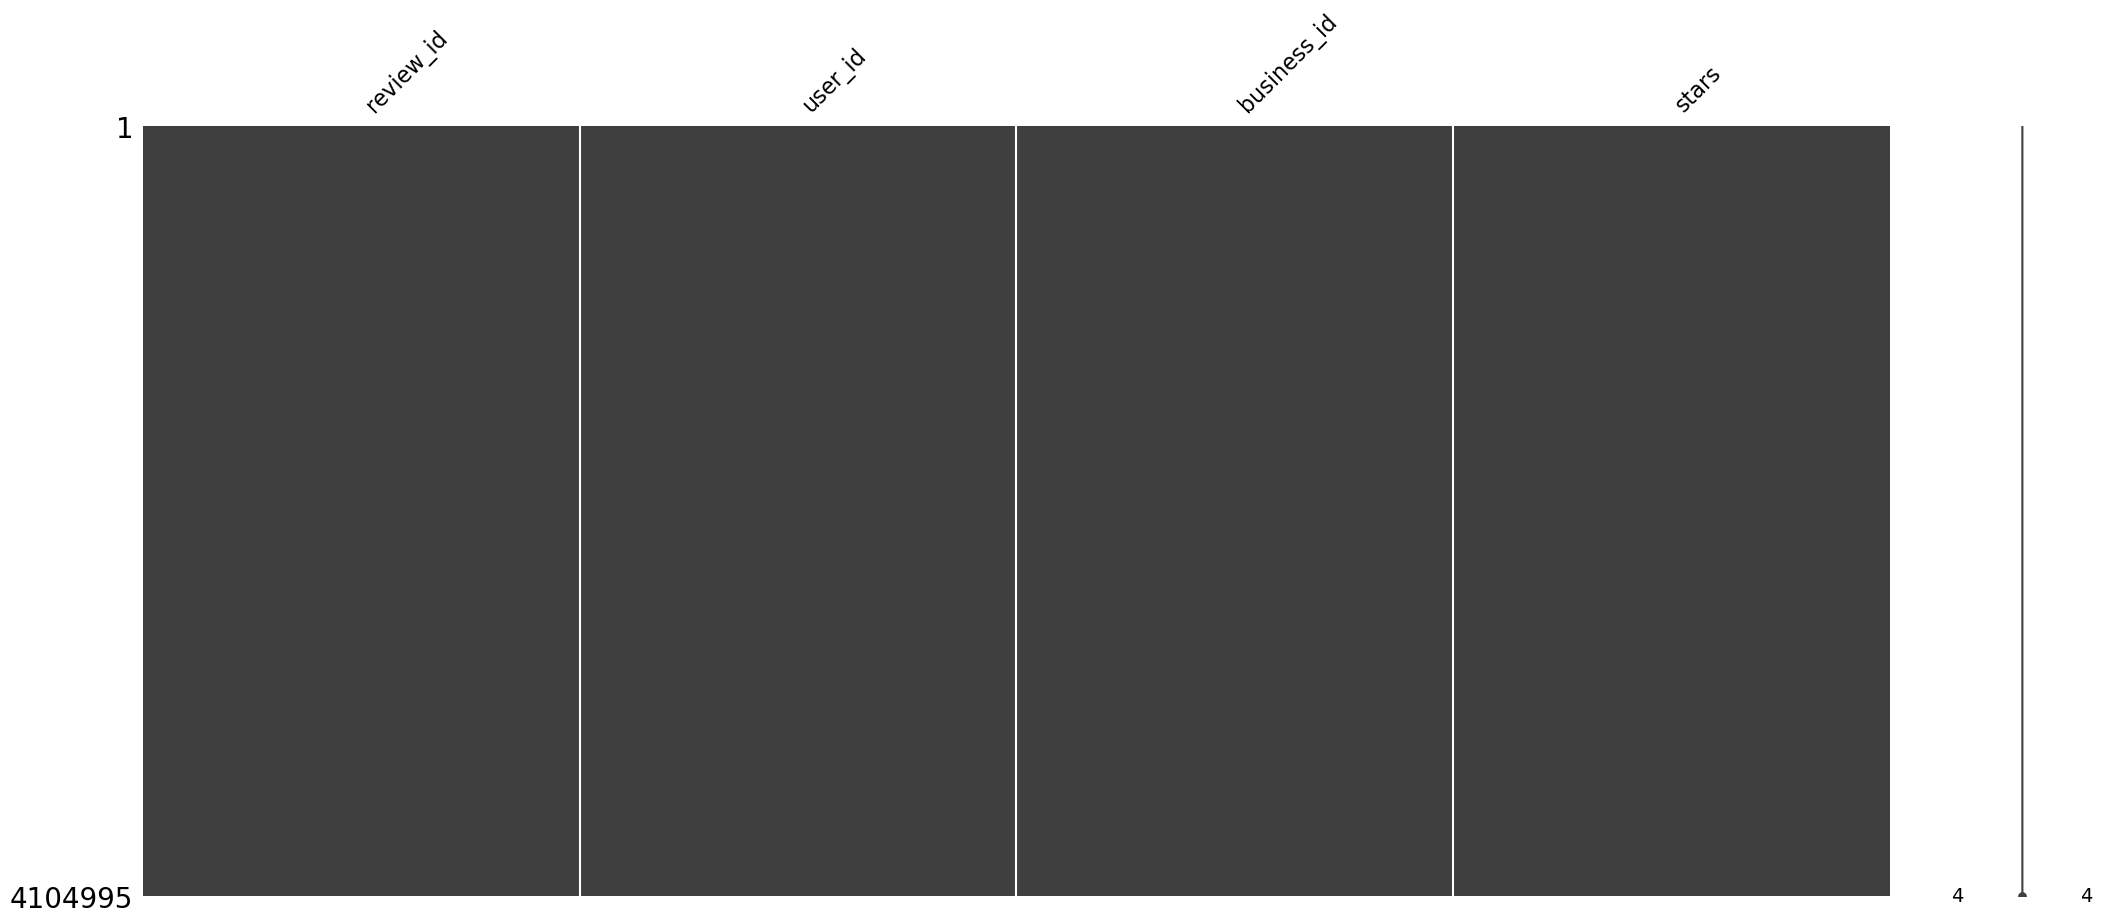

In [12]:
# Plot the missing value graph
plt.figure(figsize=(4, 2))
msno.matrix(review_clean)

# Count missing values
missing_values = [x is None or (isinstance(x, float) and np.isnan(x)) for x in review_clean]
print(f"Missing values: {sum(missing_values)}")

Luckily, there are no missing vlaues. Let's further inspect the dataset.

In [13]:
review_clean.head(5)

,review_id,user_id,business_id,stars
0,0,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3
2,2,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3
3,3,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5
9,9,59MxRhNVhU9MYndMkz0wtw,gebiRewfieSdtt17PTW6Zg,3
11,11,ZbqSHbgCjzVAqaa7NKWn5A,EQ-TZ2eeD_E0BHuvoaeG5Q,4


Furthermore, note that the `user_id` and `business_id` is messy, we want to change the `user_id` into unique numerical values and the `business_id` to restaurant names.

In [14]:
# Create a distionary mapping unique user_id to unique numerical values
user_id_mapping = {user_id: idx for idx, user_id in enumerate(review_clean['user_id'].unique())}
# Create a dictionry mapping unique business_id to restaurant name
restaurants_id_mapping = restaurants.set_index('business_id')['name'].to_dict()

# Map `user_id` and `business_id` in `review_clean`
review_clean['user_id'] = review_clean['user_id'].map(user_id_mapping)
review_clean['business_id'] = review_clean['business_id'].map(restaurants_id_mapping)

# Rename `business_id` column to `restaurant`
review_clean = review_clean.rename(columns={'business_id': 'restaurant'})

In [15]:
review_clean.head(5)

,review_id,user_id,restaurant,stars
0,0,0,Turning Point of North Wales,3
2,2,1,Kettle Restaurant,3
3,3,2,Zaika,5
9,9,3,Hibachi Steak House & Sushi Bar,3
11,11,4,Milktooth,4


#### `user_item_rating`

Let's assess the distribution of ratings per person first.

In [16]:
selected_users = review_clean["user_id"].value_counts()
selected_users

user_id
500        1461
351        1174
266         993
4199        888
195900      865
           ... 
699558        1
699560        1
14038         1
699563        1
1333168       1
Name: count, Length: 1333169, dtype: int64

Although some users rated over 1000 restaurants, a lot of them rated very few restaurants, some even only rated one. To increase usefulness of data and decrease computational burden, we want to filter out users reviewing less than 20 restaurants.

In [17]:
review_clean_20up = review_clean[review_clean["user_id"].isin(selected_users[selected_users >= 20].index)]

review_clean_20up['user_id'].nunique()

24566

Note that we're now working with only 24566 users.

We now want to create the pivot table (user-item matrix), which is essential for collborative filtering.

In [18]:
review_pivot = review_clean_20up.pivot_table(index="restaurant",columns="user_id",values="stars").fillna(0)
review_pivot.head(5)

user_id,0,1,9,10,19,20,23,28,30,31,...,610131,610611,612499,612967,622485,636698,636724,641427,659509,934670
restaurant,,,,,,,,,,,,,,,,,,,,,
#1 Mongolian BBQ - Best Stir Fried Noodles In Boise,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
$5 Fresh Burger Stop,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&pizza - UPenn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&pizza - Walnut,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&pizza - Willow Grove,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The pivot table looks nice, now we can move on to EDA.

## EDA

Here we want to look at the distributtion and relation of `user_id`, `restaurant` and `stars`.

#### Distribution of `stars` (Ratings)

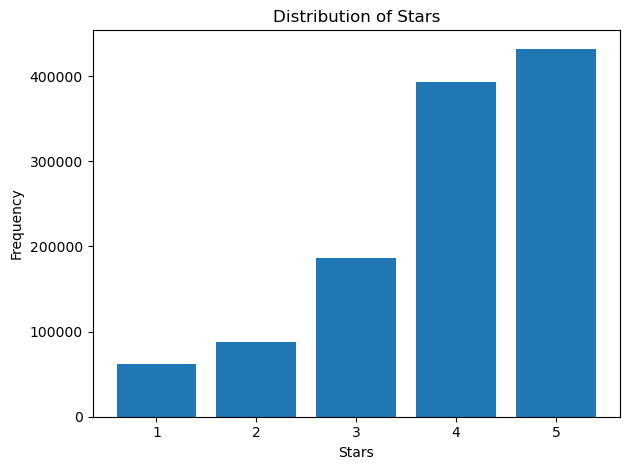

In [19]:
star_distribution = review_clean_20up['stars'].value_counts().sort_index()

# Create the bar plot
plt.bar(star_distribution.index, star_distribution.values)
plt.title('Distribution of Stars')
plt.xlabel('Stars')
plt.ylabel('Frequency')
plt.xticks(star_distribution.index)  # Ensure proper tick marks
plt.tight_layout()

# Show the plot
plt.show()

We can see that the number of ratings gets higher for higher ratings, which is highly imbalanced. An option of improvement is to standardize the ratings for each user, which will be the next step if the model's performance is not ideal.

#### Relation Between Review per User and User Rating Average

Lets look at the relation between user rating frequency and the mean review of each users.

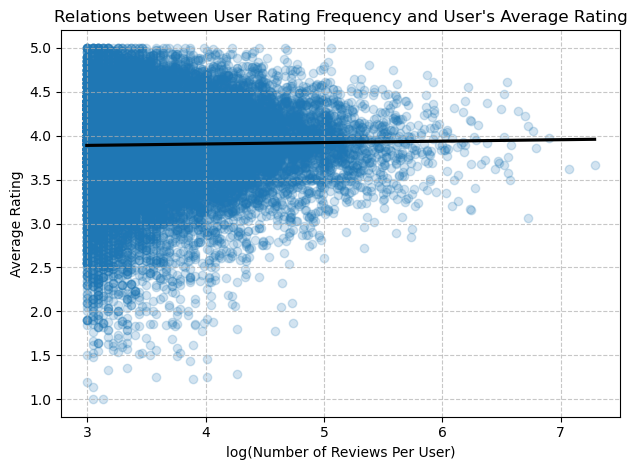

In [20]:
user_rating_trend = review_clean_20up.groupby('user_id').agg(
    reviews_per_user=('stars', 'count'),
    average_rating=('stars', 'mean')
).reset_index()
user_rating_trend['reviews_per_user'] = np.log(user_rating_trend['reviews_per_user'])

# Create the scatter plot
sns.regplot(
    data=user_rating_trend,
    x='reviews_per_user',
    y='average_rating',
    scatter_kws={'alpha': 0.2},  # Adjust transparency of scatter points
    line_kws={'color': 'black'},  # Regression line color
    ci=None  # Removes confidence interval around the regression line
)
plt.title("Relations between User Rating Frequency and User's Average Rating")
plt.xlabel('log(Number of Reviews Per User)')
plt.ylabel('Average Rating')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()

Here we assess the trend between user rating frequency and the average rating these users providing, hoping to uncover any relation of these two variables. However, we can see that the effect of a user's total review amount has little effect on the average rating the user gives, with the slope of the fitted line being very close to 0.

#### Top Rated Popular Restaurants

Let's look at some of the top rated restaurants. Since restaurants with fewer ratings (unpopular) might have only a couple high ratings and appear on the list, we want to also add a condition that the restaurants have to recieve more than 500 reviews to be considered. In other words, we're showcasing the top rated popular restaurants.

In [22]:
# Filter only restaurants with more than 1000 ratings
review_popular_restaurants = review_clean_20up.groupby('restaurant').filter(
    lambda x: x['stars'].count() > 500
)

# Find Highest and Lowest rated restaurants
mean_rating = review_popular_restaurants.groupby('restaurant')[['stars']].mean()
# Highest rated movies
highest_rated = mean_rating.sort_values(by='stars', ascending=False).head(10)

In [26]:
# Filter only restaurants with more than 1000 ratings
review_popular_restaurants = review_clean_20up.groupby('restaurant').filter(
    lambda x: x['stars'].count() > 500
)

# Find Highest and Lowest rated restaurants
mean_rating = review_popular_restaurants.groupby('restaurant')[['stars']].mean()
# Highest rated movies
highest_rated = mean_rating.sort_values(by='stars', ascending=False).head(10)
print('Highest rated restaurants:\n', highest_rated, "\n\n")
# Lowest rated movies
lowest_rated = mean_rating.sort_values(by='stars', ascending=True).head(10)
print('Lowest rated restaurants:\n', lowest_rated)


Highest rated restaurants:
                                stars
restaurant                          
Beiler's Bakery             4.632207
Reading Terminal Market     4.587660
Nothing Bundt Cakes         4.581169
Jeni's Splendid Ice Creams  4.576149
Zahav                       4.540059
Lolis Mexican Cravings      4.466270
Commander's Palace          4.449206
Total Wine & More           4.417010
Talula's Garden             4.413738
Pappy's Smokehouse          4.411854 


Lowest rated restaurants:
                               stars
restaurant                         
KFC                        2.293478
McDonald's                 2.384729
Geno's Steaks              2.400697
Burger King                2.463206
Walmart Supercenter        2.517839
Wendy's                    2.564205
Popeyes Louisiana Kitchen  2.658696
Taco Bell                  2.672330
Jack in the Box            2.673704
Pizza Hut                  2.678420


It is interesting to see that highest rated restaurants seemed to be diverse in cuisine and category, but the lowest rated restaurants seemed to all be fast food restaurants.

In the next section, we will start to fit our data to the model.

## Model Fitting and Results

### Collaborative Filtering (given an item)

The function of this model is for users to enter a restaurant they like, and the model will return 10 similar restaurants based on all user's rating pattern.

In terms of algorithms of deciding which restaurants are "similar", we will use cosine similarity.

In order to handle the matrix efficiently, we will utilize the `scipy.sparse` module given that our user-item matrix is extremely sparse. With this module we will handle the matrix in compressed sparse row (CSR) format.

In [29]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import random

data_matrix = csr_matrix(review_pivot.values)

Now we want to fit the matrix into a KNN model with cosine similarity as the metric.

In [32]:
model_knn = NearestNeighbors(metric = "cosine", algorithm = "brute")
model_knn.fit(data_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

Now let's put the model in use and see how the data performs.

In [37]:
# Randomly select a restaurant to recommend
np.random.seed(1231)
query_no = np.random.choice(review_pivot.shape[0]) 
print(f"We will find recommendations for restaurant ID number {query_no}, which is {review_pivot.index[query_no]}.")

We will find recommendations for restaurant ID number 18856, which is Ponticelli's Pizza Panini & Pasta.


In [38]:
# Recommend restaurants
distances, indices = model_knn.kneighbors(review_pivot.iloc[query_no,:].values.reshape(1, -1), n_neighbors = 11)

no = []
name = []
distance = []
rating = []

for i in range(0, len(distances.flatten())):
    if i == 0:
        print(f"Recommendations for {review_pivot.index[query_no]} diners :\n")
    else:
        print(f"{i}: {review_pivot.index[indices.flatten()[i]]} , with a distance of {distances.flatten()[i]:.4f}")        
        no.append(i)
        name.append(review_pivot.index[indices.flatten()[i]])
        distance.append(distances.flatten()[i])
        rating.append(np.mean(review_clean[review_clean["restaurant"]==review_pivot.index[indices.flatten()[i]]]["stars"].values))

Recommendations for Ponticelli's Pizza Panini & Pasta diners :

1: China Sun , with a distance of 0.4579
2: A & S Pizza & Pasta , with a distance of 0.5820
3: Zhou's House Chinese Restaurant , with a distance of 0.5878
4: La Villa Pizza & Family Restaurant , with a distance of 0.5991
5: Pasta On Time , with a distance of 0.6079
6: Chef Chun Chinese Restaurant , with a distance of 0.6155
7: D D Dairy Delite , with a distance of 0.6408
8: Joe Santucci's Square Pizza , with a distance of 0.6533
9: Yoshimoto Japanese Steakhouse , with a distance of 0.6598
10: Johnlucas Pizza Pasta And Grill , with a distance of 0.6769


In [39]:
dic = {"No" : no, "Restaurant Name" : name, "Rating" : np.round(rating, 2)}
recommendation = pd.DataFrame(data = dic)
recommendation.set_index("No", inplace = True)
recommendation

,Restaurant Name,Rating
No,,
1,China Sun,2.80
2,A & S Pizza & Pasta,4.48
3,Zhou's House Chinese Restaurant,3.24
4,La Villa Pizza & Family Restaurant,4.19
5,Pasta On Time,3.68
6,Chef Chun Chinese Restaurant,3.68
7,D D Dairy Delite,4.64
8,Joe Santucci's Square Pizza,4.00
9,Yoshimoto Japanese Steakhouse,3.61


Now, let's try with some restaurant in Isla Vista, where we're located. One of the most popular restaurant in IV is Freebirds, let's locate the index of Freebirds and then see the recommendations for Freebirds lovers.

In [40]:
# Find the row number of freebirds
freebirds_row = review_pivot.index.get_loc("Freebirds")

# Recommend restaurants like Freebirds
distances, indices = model_knn.kneighbors(review_pivot.iloc[freebirds_row,:].values.reshape(1, -1), n_neighbors = 11)

no = []
name = []
distance = []
rating = []

for i in range(0, len(distances.flatten())):
    if i == 0:
        print(f"Recommendations for {review_pivot.index[freebirds_row]} diners :\n")
    else:
        print(f"{i}: {review_pivot.index[indices.flatten()[i]]} , with a distance of {distances.flatten()[i]:.4f}")        
        no.append(i)
        name.append(review_pivot.index[indices.flatten()[i]])
        distance.append(distances.flatten()[i])
        rating.append(np.mean(review_clean[review_clean["restaurant"]==review_pivot.index[indices.flatten()[i]]]["stars"].values))

Recommendations for Freebirds diners :

1: Woodstock's Pizza Isla Vista , with a distance of 0.5927
2: Blenders In the Grass , with a distance of 0.6767
3: Cajun Kitchen Cafe , with a distance of 0.7018
4: Zodo's Bowlero Bowling & Beyond , with a distance of 0.7097
5: Bagel Cafe , with a distance of 0.7206
6: Kyle's Kitchen , with a distance of 0.7259
7: Los Agaves , with a distance of 0.7303
8: Lilly's Tacos , with a distance of 0.7373
9: Super Cucas , with a distance of 0.7462
10: Backyard Bowls , with a distance of 0.7501


Additionally, we look at the average rating of these recommendations.

In [45]:
dic = {"No" : no, "Restaurant Name" : name, "Rating" : np.round(rating, 2)}
recommendation = pd.DataFrame(data = dic)
recommendation.set_index("No", inplace = True)
recommendation

,Restaurant Name,Rating
No,,
1,Woodstock's Pizza Isla Vista,4.02
2,Blenders In the Grass,4.09
3,Cajun Kitchen Cafe,4.04
4,Zodo's Bowlero Bowling & Beyond,3.67
5,Bagel Cafe,3.75
6,Kyle's Kitchen,3.99
7,Los Agaves,4.40
8,Lilly's Tacos,4.43
9,Super Cucas,3.65


### Collborative FIltering (given a user)

The previous model takes in value of a restaurant, and then return a list of restaurants similar to the input as recommendations. Let's call this recommendation given an item. 

Alternatively, we want to create a model that recommends given a user, which takes a certain user ID as input, and then returns a list of restaurants similar to the highest rated restaurants of this user, which the user should also like.

Notice this model is built on the previous model, only with a few extra steps. Also note that we want to avoid recommending the user reataurants which they have been to already.

In [47]:
# Randomly selecet a user to provide recommendations to.
np.random.seed(1231)
user_no = np.random.choice(review_pivot.shape[1]) 
user_id = review_pivot.columns[user_no]
print(f"We will find recommendations for user {user_id}.")

We will find recommendations for user 172240.


In [48]:
# Identify the selected user's favorate restaurants
user_ratings = review_pivot[user_id] # Obtain the user's rating to all restaurants
max_rating = user_ratings.max() # Identify the user's max rating
favorite_restaurants = user_ratings[user_ratings == max_rating].index.tolist() # Create a list of the user's favorite restaurants

In [49]:
# Create a list of restaurant this user has rated, this is to prevent recommending the user restaurants he's been to
visited_restaurants = user_ratings[user_ratings != 0].index.tolist()

In [50]:
# Recommend 10 restaurant for each of the user's favorite restaurants and combine into a large list of recommendations

# Generate and store the reccomendation into lists
no = []
name = []
distance = []
rating = []

for i, restaurant in enumerate(favorite_restaurants):
    # Get restaurant index
    restaurant_row = review_pivot.index.get_loc(restaurant)
    
    # Recommend for this favorite restaurant
    distances, indices = model_knn.kneighbors(review_pivot.iloc[restaurant_row,:].values.reshape(1, -1), n_neighbors = 11)
    
    for i in range(0, len(distances.flatten())):     
        no.append(i)
        name.append(review_pivot.index[indices.flatten()[i]])
        distance.append(distances.flatten()[i])
        rating.append(np.mean(review_clean[review_clean["restaurant"]==review_pivot.index[indices.flatten()[i]]]["stars"].values))

# Combine the list into a dataframe and filter out rows with distance < 0.0001 (same restaurant)
# Also filter out restaurant that this user has rated (user already tried it)
all_recs = pd.DataFrame({
    "No": no,
    "Name": name,
    "Distance": distance,
    "Rating": rating
})
all_recs = all_recs[(all_recs["Distance"] >= 0.0001) & (~all_recs["Name"].isin(visited_restaurants))]

In [56]:
# Select the top 10 restaurants as the final recommendations and print the results
all_recs_top10 = all_recs.sort_values(by='Distance', ascending=True).head(10)
all_recs_top10["No"] = range(1, len(all_recs_top10) + 1)
all_recs_top10

header_printed = False
for i, row in all_recs_top10.iterrows():
    if not header_printed:
        print(f"Recommendations for user {user_id}:\n")
        header_printed = True
    print(f"{row['No']}: {row['Name']}, with a distance of {row['Distance']:.4f}") 


Recommendations for user 172240:

1: Di Bruno Bros. Catering & Events, with a distance of 0.5797
2: Al-Amana Grocery Store, with a distance of 0.5918
3: Messina Club, with a distance of 0.6039
4: Barbuzzo, with a distance of 0.6400
5: 9th Street Bottle Shop, with a distance of 0.6799
6: Barbuzzo, with a distance of 0.6915
7: K'Far Cafe, with a distance of 0.7064
8: Fine Wines & Good Spirits, with a distance of 0.7076
9: City Deli II, with a distance of 0.7104
10: B J's Country Store & Deli, with a distance of 0.7104


We have now successfully recommended 10 restaurants for a selected user based on their history. To take this a last step further, let's inspect the rating of these recommendations.

In [62]:
# Show the rating of the recommended retaurants
all_recs_top10['Rating'] = all_recs_top10['Rating'].round(2)
all_recs_top10[['No', 'Name', 'Rating']].rename(columns={'Name': 'Restaurant Name'})


,No,Restaurant Name,Rating
89,1,Di Bruno Bros. Catering & Events,4.50
243,2,Al-Amana Grocery Store,5.00
244,3,Messina Club,4.36
430,4,Barbuzzo,4.27
90,5,9th Street Bottle Shop,3.30
364,6,Barbuzzo,4.27
320,7,K'Far Cafe,4.44
91,8,Fine Wines & Good Spirits,2.75
178,9,City Deli II,2.93
177,10,B J's Country Store & Deli,4.80


## Conclusion

In this project, we successfully built two types of recommender systems to suggest restaurants based on either a restaurant or a user by leveraging the NearestNeighbors function from the sklearn package. We made some interesting observations about the dataset, and the performance of the first model was promising. When we input a restaurant that we are familiar with, the output included similar restaurants, aligning with our expectations.

However, for the second model, we were unable to assess its performance without receiving feedback from users who tried the recommended restaurants. A potential next step to refine this model, especially if users are dissatisfied with the recommendations, would be to standardize recommendations across all users to see if the model improves.

A more advanced enhancement would involve combining this item-based collaborative filtering approach with a user-based method, potentially integrating it with content-based models. This hybrid approach could further improve the quality of the recommendations and better address user preferences.